In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import torch
from torch.nn.functional import relu

In [2]:
my_map = [[0]*5 for _ in range(5)]
my_map[2][0] = 'Rs'
my_map[2][2] = 'Rd'
my_map[1][1] = -1
my_map[2][1] = -1
my_map[1][3] = -1
my_map[2][3] = -1
my_map[4][0] = 'Rw'
my_map[4][1] = 'Rw'
my_map[4][2] = 'Rw'
my_map[4][3] = 'Rw'
my_map[4][4] = 'Rw'

In [3]:
# this function plots a map with various ways
# given my_map, it plots the map: plot_map(my_map)
# given my_map, positions (trajectory)， it will plot it on the map: plot_map(my_map, [[0,0], [0,1], [0,2], [1,2]] )
# given my_map, positions, observations, it will plot the trajectory with the oservation: plot_map(my_map, [[0,0], [0,1], [0,2], [1,2]], [1,2,3,4])
# given my_map, values (same size with map), it will plot the values. This can be used to show action/value
def plot_map(my_map, positions=[], observations=[], values=[]):
    # draw the grid frame
    n = len(my_map)
    m = len(my_map[0])
    fig,ax = plt.subplots(figsize=(6, 6))
    
    # draw the whole grid
    for x,row in enumerate(my_map):
        for y,element in enumerate(row):
            if type(element)==type(0) and element == -1:
                ax.add_patch(Rectangle((x,y),1,1,color='lightgray'))
                ax.text(x+0.4,y+0.4,str('X'),c='black',size='xx-large')
            elif type(element)==type('str'):
                if element == 'Rw':
                    ax.add_patch(Rectangle((x,y),1,1,color='red'))
                    if len(values) == 0:
                        ax.text(x+0.35,y+0.4,element,c='black',size='xx-large')
                else:
                    ax.add_patch(Rectangle((x,y),1,1,color='lime'))
                    if len(values) == 0:
                        ax.text(x+0.35,y+0.4,element,c='black',size='xx-large')                   
    
    # if need rewards
    if len(values) > 0:
        for x,row in enumerate(my_map):
            for y,element in enumerate(row):
                if type(element)==type(0) and element == -1:
                    pass
                else:
                    ax.text(x+0.15,y+0.4,'{:.2f}'.format(values[x][y]),c='black',size='xx-large')
    else:
        # draw arrows of start
        if len(positions) > 0:
            ax.add_patch(Circle((positions[0][0]+0.5, positions[0][1]+0.5), 0.05, color='blue'))
            ax.text(positions[0][0]+0.05, positions[0][1]+0.2,'0',c='black',size='small') 
            if len(observations) > 0:
                ax.text(positions[0][0]+0.05, positions[0][1]+0.7, str(observations[0]),c='gray',size='small') 

        # draw all the movements
        max_num = len(positions)
        for num, pos in enumerate(positions[1:]):
            ax.add_patch(Circle((pos[0]+0.5, pos[1]+0.5), 0.05+0.15*(num+1)/max_num, color='blue'))
            ax.text(pos[0]+0.05+0.9*(num+1)/max_num, pos[1]+0.2, str(num+1), c='black', size='small') 
            if len(observations) == max_num:
                ax.text(pos[0]+0.05+0.9*(num+1)/max_num, pos[1]+0.7, str(observations[num+1]),c='gray',size='small') 
    
    # some configs
    plt.xticks(np.arange(n+1))
    plt.yticks(np.arange(m+1))

    ax.set_xticklabels([str(x) for x in np.arange(n+1)])
    ax.set_yticklabels([str(y) for y in np.arange(m+1)])
    
    plt.grid()
    plt.show()

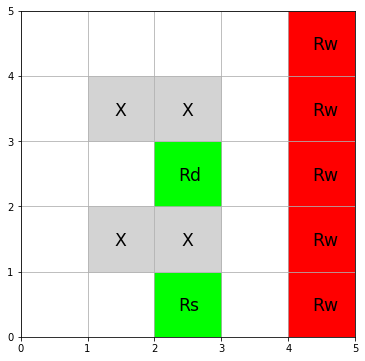

In [4]:
plot_map(my_map)

In [5]:
moves_map = {0:[0,0], 1:[-1,0], 2:[0,1], 3:[1,0], 4:[0,-1]}
# this function receive a position and action and return next position with correct randomness
def move_one_step(my_map, pos, move, pe, n=5, m=5):
    # if already stop/ never
    #if type(my_map[pos[0]][pos[1]]) == type('str'):
    #    return pos
    
    # else choose the random action
    actions = [(1-pe)/(len(moves_map)-1)] * len(moves_map)
    actions[move] = pe
    action = np.argmax(np.random.multinomial(1, actions))
    movement = moves_map[action]
    # next pois
    next_pos =[pos[0]+movement[0], pos[1]+movement[1]]
    
    # if not valid: out the map
    if next_pos[0] < 0 or next_pos[0] >= n:
        return pos
    if next_pos[1] < 0 or next_pos[1] >= m:
        return pos
    
    # else if target is obstacle
    if type(my_map[next_pos[0]][next_pos[1]]) == type(0) and my_map[next_pos[0]][next_pos[1]] == -1:
        return pos
    
    return next_pos

In [ ]:
#from http://quant.am/cs/2017/08/07/policy-gradients/

In [39]:
import random

import numpy as np
import scipy.stats

class LinearSoftmaxAgent():
    """Act with softmax policy. Features are encoded as
    phi(s, a) is a 1-hot vector of states."""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.states = []
        self.actions = []
        self.probs = []
        self.rewards = []
        self.theta = np.random.random(state_size * action_size)
        self.alpha = .01
        self.gamma = .99

    def store(self, state, action, prob, reward):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(prob)
        self.rewards.append(reward)

    def _phi(self, s, a):
        encoded = np.zeros([self.action_size, self.state_size])
        encoded[a] = s
        return encoded.flatten()

    def _softmax(self, s, a):
        return np.exp(self.theta.dot(self._phi(s, a)) / 100)

    def pi(self, s):
        """\pi(a | s)"""
        weights = np.empty(self.action_size)
        for a in range(self.action_size):
            weights[a] = self._softmax(s, a)
        return weights / np.sum(weights)

    def act(self, state):
        probs = self.pi(state)
        a = random.choices(range(0, self.action_size), weights=probs)
        a = a[0]
        pi = probs[a]
        return (a, pi)

    def _gradient(self, s, a):
        expected = 0
        probs = self.pi(s)
        for b in range(0, self.action_size):
            expected += probs[b] * self._phi(s, b)
        return self._phi(s, a) - expected

    def _R(self, t):
        """Reward function."""
        total = 0
        for tau in range(t, len(self.rewards)):
            total += self.gamma**(tau - t) * self.rewards[tau]
        return total

    def train(self):
        self.rewards -= np.mean(self.rewards)
        self.rewards /= np.std(self.rewards)
        for t in range(len(self.states)):
            s = self.states[t]
            a = self.actions[t]
            r = self._R(t)
            grad = self._gradient(s, a)
            self.theta = self.theta + self.alpha * r * grad
        # print(self.theta)
        self.states = []
        self.actions = []
        self.probs = []
        self.rewards = []

    def getName(self):
        return 'LinearSoftmaxAgent'

    def save(self):
        pass

In [40]:
pe = 0.9
H = 30
discount = 0.9
rewards_map = {'Rd' : 10, 'Rs': 10, 'Rw': -5, 0:-0.1}

In [44]:
g = LinearSoftmaxAgent(25, 5)

MAX_EPISODES = 10000
h = 0
score = 0
episode=0
while episode < MAX_EPISODES:  # episode loop
    # get state
    state = [np.random.randint(0,5), np.random.randint(0,5)]
    tmpre = my_map[state[0]][state[1]]
    while type(tmpre) == type(0) and tmpre == -1:
        state = [np.random.randint(0,5), np.random.randint(0,5)]
        tmpre = my_map[state[0]][state[1]]
        
    action, prob = g.act(state[0]*5+state[1])
    state_next = move_one_step(my_map, state, action, pe)  # take a random action
    reward = rewards_map[my_map[state[0]][state[1]]]
    score += reward
    g.store(state[0]*5 + state[1], action, prob, reward)
    
    h+=1
    if h>=30:
        episode += 1
        g.train()
        if episode%100 == 0:
            print('Episode: {} Score: {}'.format(episode, score))
        score = 0
        h = 0

Episode: 100 Score: 3.100000000000005
Episode: 200 Score: 7.700000000000003
Episode: 300 Score: -16.800000000000004
Episode: 400 Score: 12.900000000000002
Episode: 500 Score: -32.10000000000001
Episode: 600 Score: 3.1000000000000085
Episode: 700 Score: -22.299999999999997
Episode: 800 Score: -6.999999999999996
Episode: 900 Score: -2.1
Episode: 1000 Score: -16.8
Episode: 1100 Score: -2.0999999999999974
Episode: 1200 Score: -56.90000000000002
Episode: 1300 Score: -17.100000000000012
Episode: 1400 Score: -22.000000000000004
Episode: 1500 Score: 8.000000000000002
Episode: 1600 Score: -16.8
Episode: 1700 Score: -37.30000000000002
Episode: 1800 Score: -27.200000000000017
Episode: 1900 Score: 2.800000000000004
Episode: 2000 Score: -51.700000000000024
Episode: 2100 Score: -31.800000000000004
Episode: 2200 Score: -22.00000000000001
Episode: 2300 Score: -2.1
Episode: 2400 Score: -22.0
Episode: 2500 Score: -7.0
Episode: 2600 Score: -2.100000000000005
Episode: 2700 Score: 8.299999999999992
Episode

In [ ]:
plot_map(my_map, track)

In [ ]:
pe = 0.9
H = 30
discount = 0.9
rewards_map = {'Rd' : 10, 'Rs': 10, 'Rw': -5, 0:-0.1}

In [52]:
class Myenv():
    def __init__(self, my_map, rewards_map, pe, H):
        self.my_map = my_map
        self.rewards_map = rewards_map
        self.pe = pe
        self.H = H
        self.h = 0
    
    def reset(self):
        state = [np.random.randint(0,5), np.random.randint(0,5)]
        tmpre = my_map[state[0]][state[1]]
        while type(tmpre) == type(0) and tmpre == -1:
            state = [np.random.randint(0,5), np.random.randint(0,5)]
            tmpre = my_map[state[0]][state[1]]
        s = np.hstack([np.zeros([1,10]), np.ones([1,10])])
        s[0, 0 + state[0]] = 1.0
        s[0, 5 + state[1]] = 1.0
        s[0,10 + state[0]] = 0.0
        s[0,15 + state[1]] = 0.0
        
        self.state = state
        
        self.h = 0
        return s
    
    def step(self, action):
        state = move_one_step(self.my_map, self.state, action, self.pe, n=5, m=5)
        r = self.rewards_map[self.my_map[state[0]][state[1]]]
        
        s = np.hstack([np.zeros([1,10]), np.ones([1,10])])
        s[0, 0 + state[0]] = 1.0
        s[0, 5 + state[1]] = 1.0
        s[0,10 + state[0]] = 0.0
        s[0,15 + state[1]] = 0.0
        
        self.state = state
        self.h += 1
        done = False
        if self.h >= self.H:
            done = True
        
        return s, r, done, 0

In [54]:
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical



class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(20, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, 5)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + discount * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def main():
    running_reward = 10
    for i_episode in count(1):
        state, ep_reward = env.reset(), 0
        for t in range(1, 10000):  # Don't infinite loop while learning
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % 100 == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))

env = Myenv(my_map, rewards_map, pe, H)
main()

Episode 100	Last reward: -3.00	Average reward: -14.63
Episode 200	Last reward: 47.50	Average reward: -8.97
Episode 300	Last reward: -30.60	Average reward: -19.44
Episode 400	Last reward: -90.60	Average reward: -15.05
Episode 500	Last reward: -3.00	Average reward: -19.84
Episode 600	Last reward: -90.90	Average reward: -21.45
Episode 700	Last reward: -3.00	Average reward: -10.26
Episode 800	Last reward: -76.50	Average reward: -1.82
Episode 900	Last reward: 42.60	Average reward: 4.57
Episode 1000	Last reward: -3.00	Average reward: -0.56
Episode 1100	Last reward: -66.40	Average reward: -25.96
Episode 1200	Last reward: -41.30	Average reward: -4.92
Episode 1300	Last reward: 48.10	Average reward: -5.41
Episode 1400	Last reward: -3.00	Average reward: 2.39
Episode 1500	Last reward: -3.00	Average reward: -6.97
Episode 1600	Last reward: -91.20	Average reward: -9.87
Episode 1700	Last reward: -30.90	Average reward: -2.03
Episode 1800	Last reward: -7.00	Average reward: -14.48
Episode 1900	Last rewar

KeyboardInterrupt: 